In [66]:
# Importing the usefull libraries

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(1, "../scripts")
from ml_processors import ML_Processor as MLP
from models import ML_Models

mlp = MLP()
mlm = ML_Models()


In [67]:
# Reading and assigning a variable to the respective datasets

cm_data =  pd.read_csv('../data/chrome_data.csv')
cm_w_data =  pd.read_csv('../data/chrome_mobile_webview_data.csv')
fb_data =  pd.read_csv('../data/facebook_data.csv')
pl_5_data =  pd.read_csv('../data/platform_5.csv')
pl_6_data =  pd.read_csv('../data/platform_6.csv')


In [68]:

# separating categorical and numerical variables

cat2, num2 = mlp.sep_cat_num(cm_data)
cat3, num3 = mlp.sep_cat_num(cm_w_data)
cat4, num4 = mlp.sep_cat_num(fb_data)
cat5, num5 = mlp.sep_cat_num(pl_5_data)
cat6, num6 = mlp.sep_cat_num(pl_6_data)

In [69]:
# Describing the catagorical variables 

cm_data[cat2].describe()

,auction_id,experiment,date,device_make
count,695,695,695,695
unique,695,2,8,14
top,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-03,Generic Smartphone
freq,1,371,176,665


In [70]:
# Using pipeline for the Machine learning

def processor_pipe(categories):
    pipe_1 = Pipeline(
        steps=[
            ("label categories", FunctionTransformer(mlp.cat_labeler, kw_args={"cat_cols": categories})),
            ("scale data", FunctionTransformer(mlp.scaler)),
            ("separate target and features", FunctionTransformer(mlp.target_feature, kw_args={"f_r": [0, 6], "t":-1})),
            ("divide dataset", FunctionTransformer(mlp.set_splitter, kw_args={"test": 0.1, "val":0.2, "rand_state":8})),      
            ])
    return pipe_1

pipe_1 = processor_pipe(cat2)
pipe_2 = processor_pipe(cat5)
chrome_set = pipe_1.fit_transform(cm_data)
chrome_mobile_set = pipe_1.fit_transform(cm_w_data)
facebook_set = pipe_1.fit_transform(fb_data)
platform_5_set = pipe_2.fit_transform(pl_5_data)
platform_6_set = pipe_2.fit_transform(pl_6_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted
catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted
catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted
catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted
catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [71]:
# Creating a ML pipeline for all the datasets

pipe_chrome =Pipeline([('scalar1',StandardScaler()),('lr_classifier',LogisticRegression(random_state=2))])
pipe_chrome_webview =Pipeline([('scalar1',StandardScaler()),('lr_classifier',LogisticRegression(random_state=2))])
pipe_facebook =Pipeline([('scalar1',StandardScaler()),('lr_classifier',LogisticRegression(random_state=2))])
pipe_pl_5 =Pipeline([('scalar1',StandardScaler()),('lr_classifier',LogisticRegression(random_state=2))])
pipe_pl_6 =Pipeline([('scalar1',StandardScaler()),('lr_classifier',LogisticRegression(random_state=2))])

In [72]:
# Finding and printing accuracy score of the Logistic regression for the chrome dataset

chrome_model = pipe_chrome.fit(chrome_mobile_set[0], chrome_mobile_set[1])
result = pipe_chrome.score(chrome_mobile_set[4],chrome_mobile_set[5])

print(f'The accuracy we get using the chrome mobile webview data is: {result}')

The accuracy we get using the chrome mobile webview data is: 0.4864864864864865


In [73]:
# Finding and printing accuracy score of the Logistic regression for the chrome mobile view dataset


pipe_chrome_webview.fit(chrome_set[0], chrome_set[1])
result = pipe_chrome_webview.score(chrome_set[4],chrome_set[5])

print(f'The accuracy we get using the chrome mobile data is: {result}')

The accuracy we get using the chrome mobile data is: 0.5663716814159292


In [74]:
# Finding and printing accuracy score of the Logistic regression for the facebook dataset


pipe_facebook.fit(facebook_set[0], facebook_set[1])
result = pipe_facebook.score(facebook_set[4],facebook_set[5])

print(f'The accuracy we get using the facebook data is: {result}')

The accuracy we get using the facebook data is: 0.46153846153846156


In [75]:
# Finding and printing accuracy score of the Logistic regression for the platform 5 dataset


pipe_pl_5.fit(platform_5_set[0], platform_5_set[1])
result = pipe_pl_5.score(platform_5_set[4],platform_5_set[5])

print(f'The accuracy we get using the platform 5 data is: {result}')

The accuracy we get using the platform 5 data is: 0.5025125628140703


In [76]:
# Finding and printing accuracy score of the Logistic regression for the platform 6 dataset

pipe_pl_6.fit(platform_6_set[0], platform_6_set[1])
result = pipe_pl_6.score(platform_6_set[4],platform_6_set[5])

print(f'The accuracy we get using the platform 6 data is: {result}')

The accuracy we get using the platform 6 data is: 0.3333333333333333


In [77]:
# Defining a simple function that will find our variable names

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [78]:
# Putting the datasets in to a list for simpler access

clean_data_list = [cm_data,cm_w_data,fb_data,pl_5_data,pl_6_data]

In [79]:
# Validating using KFold of 5

model=LogisticRegression()
kfold_validation=KFold(5)

In [80]:
# Looping through all the dataset and find the accuracy aswell as the loss function by using cross validation

for clean_data in clean_data_list:
  X = clean_data.iloc[:,:6]
  y = clean_data.iloc[:,-1]
  results=cross_val_score(model,X,y,cv=kfold_validation)
  name = namestr(clean_data,globals())
  print(f'Result of {name[0]}\n')
  print(results)
  print(np.mean(results),'\n')
  print('#################################')
  print('\n')

Result of cm_data

[0.53956835 0.5323741  0.55395683 0.50359712 0.56834532]
0.539568345323741 

#################################


Result of cm_w_data

[0.5        0.43478261 0.57777778 0.44444444 0.51111111]
0.4936231884057971 

#################################


Result of fb_data

[0.5        0.58064516 0.41935484 0.41935484 0.5483871 ]
0.4935483870967742 

#################################


Result of pl_5_data

[0.5203252  0.52653061 0.51836735 0.53469388 0.54693878]
0.529371163099386 

#################################


Result of pl_6_data

[0.75       0.75       0.66666667 1.         0.33333333]
0.7 

#################################




##### From the above k_fold validation we can see that the maximum accuracy we can get by using 5 fold and logistic regression is 0.75 from all the datasets. From this we can infer that either the data is not enough or the model is not suitable since the accuracy is less than 80%

In [81]:
# Splitting the data for feature importance analysis

X_cm = cm_data.iloc[:,:6]
y_cm = cm_data.iloc[:,-1]
x_main,x_test,y_main,y_test = train_test_split(X_cm,y_cm,test_size=0.1)
x_train,x_valid,y_train,y_valid = train_test_split(x_main,y_main,test_size=0.22)

In [82]:
# Modeling the chrome data and finding the accuracy

model_cm = LogisticRegression()
model_cm.fit(x_train,y_train)
model_cm.score(x_valid,y_valid)

0.5507246376811594

In [83]:
# Finding the intercept of our regression model

model_cm.intercept_

array([-0.60782239])

In [84]:
# Findig the coeficient lists of our model

coefitients_cm = model_cm.coef_

In [85]:
# Creating a features dataframe to see the importance

features_browser = ['auction_id','experiment','date','hour','device_make','platform_os']
features_platform = ['auction_id','experiment','date','hour','device_make','browser']
feature_importance_cm_df = pd.DataFrame(features_browser,columns=['Feature'])

In [86]:
# Creating a new column for the feature importance

feature_importance_cm_df['Feature\'s importance'] = pow(math.e,np.array(coefitients_cm[0]))
feature_importance_cm_df.head(10)

,Feature,Feature's importance
0,auction_id,1.118831
1,experiment,1.011738
2,date,0.976154
3,hour,1.827464
4,device_make,2.209941
5,platform_os,1.000000


In [87]:
# Sorting the table by the feature importance metrics

feature_importance_cm_df = feature_importance_cm_df.sort_values(by="Feature's importance")
feature_importance_cm_df.head(10)

,Feature,Feature's importance
2,date,0.976154
5,platform_os,1.000000
1,experiment,1.011738
0,auction_id,1.118831
3,hour,1.827464
4,device_make,2.209941


Text(0.5, 1.0, 'Feature importance for the chrome dataset')

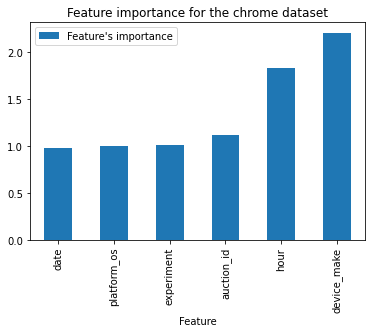

In [88]:
# Ploting the feature importance graph for the chrome data

feature_importance_cm_df.plot.bar(x='Feature', y="Feature's importance", rot=90)
plt.title('Feature importance for the chrome dataset')

Text(0.5, 1.0, 'Feature importance for the chrome mobile webview dataset')

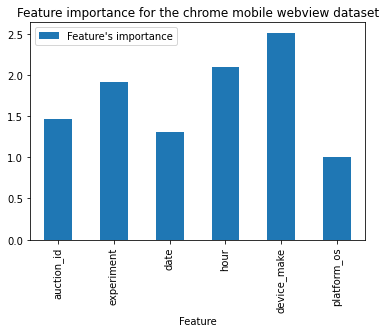

In [89]:
# Ploting the feature importance graph for the chrome mobile view data

X_cm_w = cm_w_data.iloc[:,:6]
y_cm_w = cm_w_data.iloc[:,-1]
x_main,x_test,y_main,y_test = train_test_split(X_cm_w,y_cm_w,test_size=0.1)
x_train,x_valid,y_train,y_valid = train_test_split(x_main,y_main,test_size=0.22)
model_cm_w = LogisticRegression()
model_cm_w.fit(x_train,y_train)
model_cm_w.score(x_valid,y_valid)
coefitients_cm_w = model_cm_w.coef_
feature_importance_cm_w_df = pd.DataFrame(features_browser,columns=['Feature'])
feature_importance_cm_w_df['Feature\'s importance'] = pow(math.e,np.array(coefitients_cm_w[0]))
feature_importance_cm_w_df.plot.bar(x='Feature', y="Feature's importance", rot=90)
plt.title('Feature importance for the chrome mobile webview dataset')

Text(0.5, 1.0, 'Feature importance for the facebook dataset')

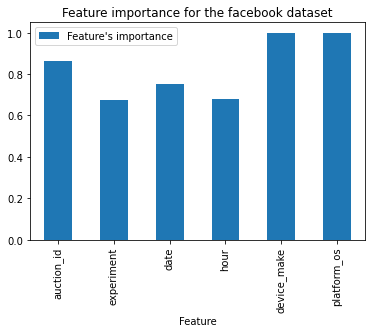

In [90]:
# Ploting the feature importance graph for the facebook data

X_fb = fb_data.iloc[:,:6]
y_fb = fb_data.iloc[:,-1]
x_main,x_test,y_main,y_test = train_test_split(X_fb,y_fb,test_size=0.1)
x_train,x_valid,y_train,y_valid = train_test_split(x_main,y_main,test_size=0.22)
model_fb = LogisticRegression()
model_fb.fit(x_train,y_train)
model_fb.score(x_valid,y_valid)
coefitients_fb = model_fb.coef_
feature_importance_fb_df = pd.DataFrame(features_browser,columns=['Feature'])
feature_importance_fb_df['Feature\'s importance'] = pow(math.e,np.array(coefitients_fb[0]))
feature_importance_fb_df.plot.bar(x='Feature', y="Feature's importance", rot=90)
plt.title('Feature importance for the facebook dataset')

Text(0.5, 1.0, 'Feature importance for the platform 5 dataset')

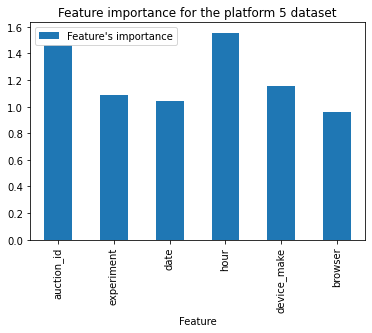

In [91]:
# Ploting the feature importance graph for the platform 5 data

X_pl_5 = pl_5_data.iloc[:,:6]
y_pl_5 = pl_5_data.iloc[:,-1]
x_main,x_test,y_main,y_test = train_test_split(X_pl_5,y_pl_5,test_size=0.1)
x_train,x_valid,y_train,y_valid = train_test_split(x_main,y_main,test_size=0.22)
model_pl_5 = LogisticRegression()
model_pl_5.fit(x_train,y_train)
model_pl_5.score(x_valid,y_valid)
coefitients_pl_5 = model_pl_5.coef_
feature_importance_pl_5_df = pd.DataFrame(features_platform,columns=['Feature'])
feature_importance_pl_5_df['Feature\'s importance'] = pow(math.e,np.array(coefitients_pl_5[0]))
feature_importance_pl_5_df.plot.bar(x='Feature', y="Feature's importance", rot=90)
plt.title('Feature importance for the platform 5 dataset')

Text(0.5, 1.0, 'Feature importance for the platform 6 dataset')

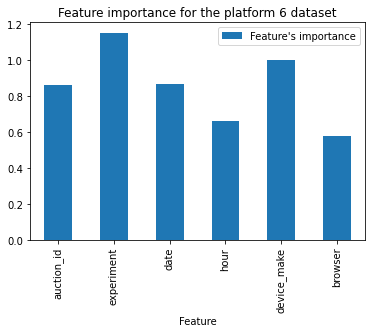

In [92]:
# Ploting the feature importance graph for the platform 6 data

X_pl_6 = pl_6_data.iloc[:,:6]
y_pl_6 = pl_6_data.iloc[:,-1]
x_main,x_test,y_main,y_test = train_test_split(X_pl_6,y_pl_6,test_size=0.1)
x_train,x_valid,y_train,y_valid = train_test_split(x_main,y_main,test_size=0.22)
model_pl_6 = LogisticRegression()
model_pl_6.fit(x_train,y_train)
model_pl_6.score(x_valid,y_valid)
coefitients_pl_6 = model_pl_6.coef_
feature_importance_pl_6_df = pd.DataFrame(features_platform,columns=['Feature'])
feature_importance_pl_6_df['Feature\'s importance'] = pow(math.e,np.array(coefitients_pl_6[0]))
feature_importance_pl_6_df.plot.bar(x='Feature', y="Feature's importance", rot=90)
plt.title('Feature importance for the platform 6 dataset')